In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "24"

import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scanpy as sc
from hits.visualize import interactive
from bokeh.io import output_notebook
from hdbscan import HDBSCAN

from perturbseq import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

Loading BokehJS ...

# Parameters

In [2]:
full_pop = sc.read_h5ad('/data/norman/southark/tfs_standardized/240118_RPE1_CRISPRa_scanpy_from_cellranger_aggr_singlets_and_multiplets_5umi_guide_thresh.h5ad')

In [3]:
full_pop = full_pop[:, full_pop.var['mean'] > 0].copy()

In [4]:
full_pop = CellPopulation(pd.DataFrame(full_pop.X.todense().A, index=full_pop.obs.index, columns=full_pop.var.index), full_pop.obs, full_pop.var, calculate_statistics=False)

Done.


In [5]:
full_pop.cells['guide_identity'] = full_pop.cells['guide_identity'].astype(str)
full_pop.cells['guide_target'] = full_pop.cells['guide_identity'].map(lambda x: x.split('_')[0])
full_pop.genes['in_matrix'] = True

In [6]:
full_pop.cells['gem_group'] = full_pop.cells.index.map(lambda x: int(x.split('-')[1]))

# Droplet quality filtering

In [7]:
full_pop.cells.groupby('gem_group')['UMI_count'].mean()

gem_group
0     9342.708008
1     9428.358398
2     9300.682617
3     9417.412109
4     9445.224609
5     9441.197266
6     9245.638672
7     9009.696289
8     9331.864258
9     9370.322266
10    8965.590820
11    9340.458984
12    9476.726562
13    9535.160156
14    8498.010742
15    9301.751953
16    9601.208984
17    8777.669922
18    8987.893555
19    9389.942383
Name: UMI_count, dtype: float32

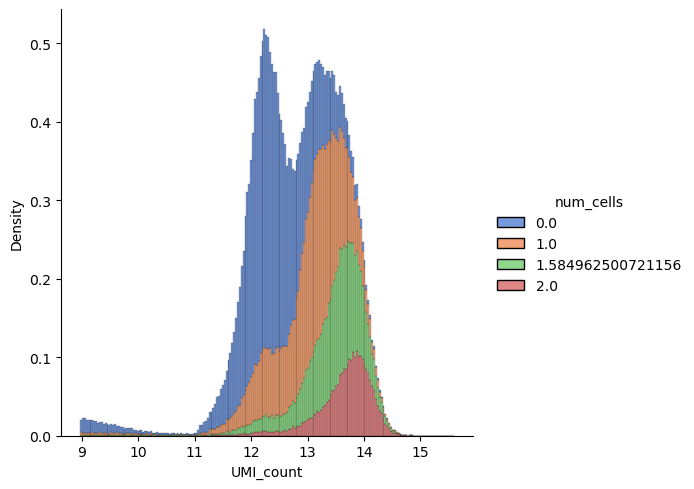

In [8]:
sns.displot(data=np.log2(full_pop.cells.query('gem_group <= 9 and num_cells <= 4')[['UMI_count', 'num_cells']]), x='UMI_count', hue='num_cells', palette='muted', stat='density', multiple='stack')

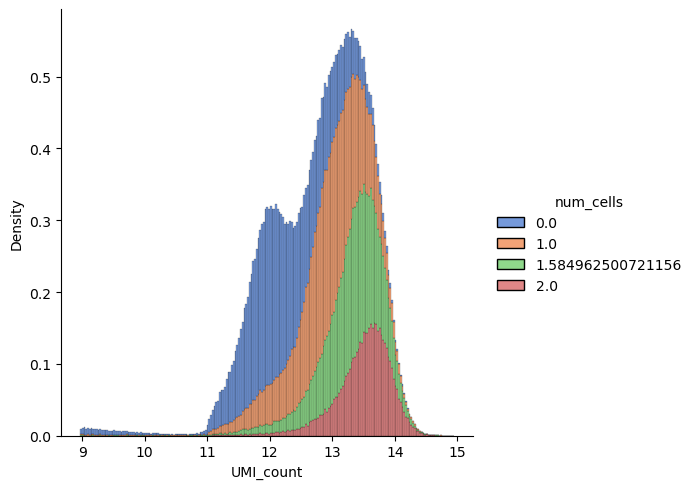

In [9]:
sns.displot(data=np.log2(full_pop.cells.query('gem_group > 9 and num_cells <= 4')[['UMI_count', 'num_cells']]), x='UMI_count', hue='num_cells', palette='muted', stat='density', multiple='stack')

In [10]:
UMI_thresholds = {1: 2**11, 2: 2**11, 3: 2**11.3, 4: 2**11.7}

In [11]:
df = full_pop.cells.query('gem_group==1 and num_cells <= 4')[['UMI_count', 'num_cells']]

In [12]:
df.columns = ['UMI count', 'number of cells in droplet']

(0.0, 30000.0)

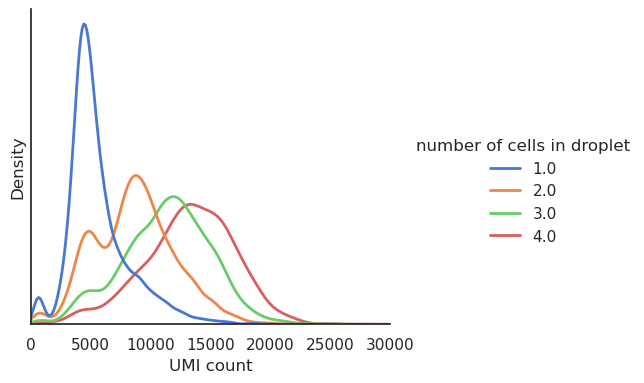

In [13]:
sns.set(font_scale=1)
sns.set_style('white')
sns.displot(data=df,
            x='UMI count', hue='number of cells in droplet', palette='muted', kind='kde', common_norm=False,
           height=4, aspect=1.25, linewidth=2)
plt.yticks([])
plt.xlim([0, 30000])

In [14]:
df = full_pop.cells.query('gem_group==1 and num_cells <= 10')[['UMI_count', 'num_cells']].groupby('num_cells').median()

Text(0, 0.5, 'Median UMI count')

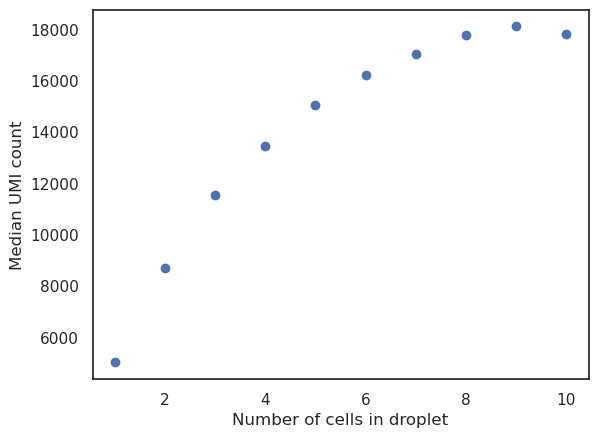

In [15]:
plt.scatter(df.index, df['UMI_count'])
plt.xlabel('Number of cells in droplet')
plt.ylabel('Median UMI count')

In [16]:
mt_genes = full_pop.genes[full_pop.genes['gene_name'].str.startswith('MT-')].query('mean > 1').index
full_pop.cells['mt_frac'] = full_pop.matrix[mt_genes].sum(axis=1)/full_pop.cells['UMI_count']

(0.0, 20000.0)

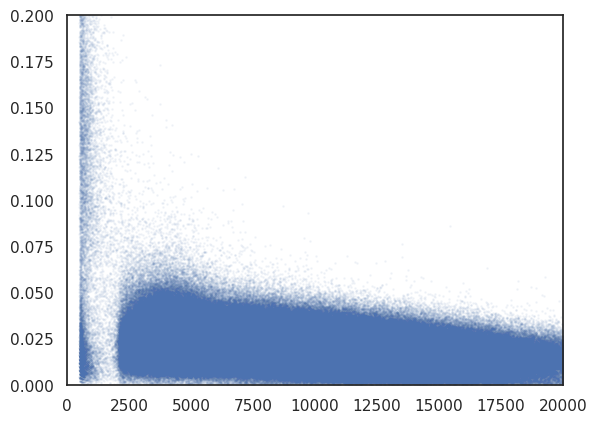

In [17]:
plt.scatter(full_pop.cells['UMI_count'], full_pop.cells['mt_frac'], s=1, alpha=0.05)
plt.ylim([0, 0.2])
plt.xlim([0, 20000])

In [18]:
full_pop.cells['keep'] = (full_pop.cells['UMI_count'] > full_pop.cells['num_cells'].map(UMI_thresholds)) \
                          & (full_pop.cells['mt_frac'] < 0.075)

In [19]:
full_pop.cells.query('keep').groupby('num_cells')['num_cells'].sum().head(10)

num_cells
1.0    321770.0
2.0    506226.0
3.0    510210.0
4.0    421088.0
Name: num_cells, dtype: float64

In [20]:
full_pop.cells.query('keep').groupby('gem_group')['num_cells'].sum()

gem_group
0      58176.0
1      58929.0
2      47301.0
3      66028.0
4      61283.0
5      74051.0
6      71631.0
7      73023.0
8      73335.0
9      63760.0
10    107554.0
11    112302.0
12    103264.0
13    109720.0
14    108900.0
15    112824.0
16    115600.0
17    113521.0
18    115267.0
19    112825.0
Name: num_cells, dtype: float64

In [21]:
full_pop.cells['single_cell'] = True

In [22]:
full_pop = full_pop.subpopulation(cells='keep')

Generating summary statistics...
Done.


# Filtering of control guides for possible on-target effects

In [25]:
expr = full_pop.where('guide_target=="non" and num_cells==1', genes='mean > 1')
expr['guide_identity'] = full_pop.cells['guide_identity']
expr.set_index('guide_identity', append=True, inplace=True)
expr = (expr - expr.mean()).div(expr.std())

In [26]:
scores = pd.read_csv('20231027_sequence_scores.csv', index_col=0)['0']

In [27]:
counts = full_pop.cells.query('num_cells==1 and guide_target=="non"').groupby('guide_identity').count()['UMI_count'].sort_values()
counts.head(20)

guide_identity
non_targeting_GTGGATTATCTGACGCGAAT     75
non_targeting_GTTGATCGACCGATTGCGAT     79
non_targeting_GGAATCCAGCTCGACGACCA     86
non_targeting_GTAAATTCTCGCGTAACGTT     99
non_targeting_GATGCTCGCAGTTCGACCGC    101
non_targeting_GCTGTTTCGACCCGTCGAAT    102
non_targeting_GACTGAAAGCCGATATCGGG    102
non_targeting_GTGGTTATACCCGACTAGAC    109
non_targeting_GTGTTTTTCGGTCGGCCGAT    110
non_targeting_GGGTCGTAGAACTAGCGCAA    111
non_targeting_GCCTAAATACTATTCGCGGA    116
non_targeting_GTCGTTATCTCGCTATTTCG    124
non_targeting_GGCTTCTACACCGCGATGAC    125
non_targeting_GGATGAAAACCCGAACCGAT    134
non_targeting_GAGATATGAGGCGACGATAT    138
non_targeting_GAAACAAACAGACGGACCTA    141
non_targeting_GACCAGCATTCATACGCCGG    141
non_targeting_GCGGGTAGCTTATATAGCGC    144
non_targeting_GTCAATACGACGAGCCGACA    145
non_targeting_GATAAGTCGTCGTCCAATCG    145
Name: UMI_count, dtype: int64

In [28]:
mean_expr = expr.groupby(level=1).mean()

In [29]:
control_guide_scores = pd.Series(mean_expr.index.map(lambda x: x[-5:]).map(scores), index=mean_expr.index)

In [30]:
control_guide_scores.sort_values().dropna().tail(20)

guide_identity
non_targeting_GTGCATCAAGTCGACCGGCG    11.698591
non_targeting_GCTCTTGGTACGTATTCGAA    11.793140
non_targeting_GGATGTCGCCACGTACGGAT    12.020473
non_targeting_GTCAATACGACGAGCCGACA    12.143612
non_targeting_GAAACAAACAGACGGACCTA    12.603942
non_targeting_GAACGGGCCGTGATCGGACC    13.147390
non_targeting_GACCAGCATTCATACGCCGG    13.827048
non_targeting_GCTTCGGGGGAATCACCGGT    14.065916
non_targeting_GACCACCGACGCGTTACGCA    14.175489
non_targeting_GCTCTGTTCGTCGTTCGCTG    14.206585
non_targeting_GCCAGACGCGCCCGTAACGG    14.662778
non_targeting_GACGAATGAAGCGTCGATAA    16.714623
non_targeting_GGCTTCTACACCGCGATGAC    16.859756
non_targeting_GGGAACAGGGGCGGTCCGTA    16.995683
non_targeting_GAGATATGAGGCGACGATAT    17.883156
non_targeting_GTCCATAGGGTCTAGCGCCG    21.004817
non_targeting_GAAGCAGCATGAATACGCCG    21.004817
non_targeting_GACTGAAAGCCGATATCGGG    22.914654
non_targeting_GCCTAAATACTATTCGCGGA    25.215185
non_targeting_GGAATCCAGCTCGACGACCA    26.143064
Name: guide_identity, dty

In [31]:
len(np.intersect1d(counts[counts > 100].index, control_guide_scores[(control_guide_scores < 15) | control_guide_scores.isnull()].index))

66

In [34]:
good_controls = np.intersect1d(counts[counts > 100].index, control_guide_scores[(control_guide_scores < 15) | control_guide_scores.isnull()].index)

In [35]:
full_pop.cells.query('num_cells==1 and guide_identity in @good_controls').groupby('gem_group').count()

,old_barcode,dataset,batch,UMI_count,guide_identity,guide_umi_count,thresholded_features,thresholded_guide_umi,num_cells,guide_target,mt_frac,keep,single_cell
gem_group,,,,,,,,,,,,,
0,542,542,542,542,542,542,542,542,542,542,542,542,542
1,509,509,509,509,509,509,509,509,509,509,509,509,509
2,372,372,372,372,372,372,372,372,372,372,372,372,372
3,567,567,567,567,567,567,567,567,567,567,567,567,567
4,491,491,491,491,491,491,491,491,491,491,491,491,491
5,838,838,838,838,838,838,838,838,838,838,838,838,838
6,780,780,780,780,780,780,780,780,780,780,780,780,780
7,773,773,773,773,773,773,773,773,773,773,773,773,773
8,754,754,754,754,754,754,754,754,754,754,754,754,754


In [36]:
full_pop.cells['control'] = (full_pop.cells['num_cells'] == 1) & (full_pop.cells['guide_identity'].isin(good_controls))

# Save total UMI count population

In [38]:
from scipy.sparse import csr_matrix

In [39]:
adata = sc.AnnData(X=csr_matrix(full_pop.matrix),
                   obs=full_pop.cells,
                   var=full_pop.genes)

In [40]:
adata.write('/data/norman/southark/tfs_standardized/240308_RPE1_CRISPRa_scanpy_from_cellranger_aggr_singlets_and_multiplets_5umi_guide_thresh_filtered_all_UMI_counts.h5ad')

# Identify stably captured genes

In [48]:
def get_p(pop, genes=None, UMI_counts=None):
    if UMI_counts is None:
        UMI_counts = pop.cells['UMI_count']
    
    ps = dict()
    
    for gem in tqdm(pop.cells['gem_group'].unique()):
        gem_group_cells = pop.cells[pop.cells['gem_group']==gem].index
        
        p = pop.where(cells=gem_group_cells, genes=genes).copy()
        # normalize to probabilities
        p = p.div(UMI_counts.loc[gem_group_cells], axis=0)
                    
        ps[gem] = p
    
    ps = pd.concat(ps.values())

    return ps

In [49]:
def get_stratified_expression(pop, stratify, cells=None, genes=None, normalized=False, normalized_name=None, **kwargs):
    expr = pop.where(cells=cells, genes=genes, normalized=normalized, normalized_name=normalized_name, **kwargs).copy()
    
    for key in stratify:
        expr[key] = pop.cells[key]
        
    expr.set_index(stratify, append=True, inplace=True)
    levels_order = expr.index.names
    new_order = levels_order[1:] + [levels_order[0]]
    expr = expr.reorder_levels(new_order)

    return expr

In [50]:
from scipy.stats import wasserstein_distance

def pairwise_sum_wasserstein(p):
    num_cells = p.index.get_level_values(0).unique()
    
    dists = list()
    for (n1, n2) in combinations(num_cells, 2):
        dists.append(wasserstein_distance(p.loc[n1], p.loc[n2]))
    return np.sum(dists)

In [51]:
full_pop.normalized_matrix = dict()

In [52]:
full_pop.normalized_matrix['p'] = get_p(full_pop)

  0%|          | 0/20 [00:00<?, ?it/s]

In [53]:
p = get_stratified_expression(full_pop,
                              ['gem_group', 'num_cells'],
                              genes='mean > 0.5',
                              normalized=True, normalized_name='p')

In [54]:
from itertools import combinations

In [56]:
def process_gem_group(gem_group):
    local_dists = dict()
    gem_group_p = p.loc[gem_group]
    for gene, col in gem_group_p.iteritems():
        local_dists[(gem_group, gene)] = pairwise_sum_wasserstein(col)
    return local_dists

# Parallelize the outer loop
n_jobs = 10  # Use all available cores
gem_groups = p.index.get_level_values(0).unique()
results = Parallel(n_jobs=n_jobs)(delayed(process_gem_group)(gem_group) for gem_group in tqdm(gem_groups, total=len(gem_groups)))

# Merge the results from all workers into the main dict
dists = {k: v for res in results for k, v in res.items()}

  0%|          | 0/20 [00:00<?, ?it/s]

In [57]:
full_pop.genes['pairwise_p_cost'] = np.log10(pd.Series(dists).unstack().sum())

In [58]:
def pairwise_sum_hellinger(p):
    num_cells = p.index.get_level_values(0).unique()
    
    dists = list()
    for (n1, n2) in combinations(num_cells, 2):
        dists.append(empirical_hellinger(p.loc[n1], p.loc[n2]))
    return np.sum(dists)

## Fitting adjusted total cost

In [61]:
from sklearn.linear_model import HuberRegressor

regr = HuberRegressor()
X = np.log10(full_pop.genes.query('mean > 0.5')['mean']).values.reshape(-1, 1)
y = full_pop.genes.query('mean > 0.5')['pairwise_p_cost']

regr.fit(X, y)
pred_costs = pd.Series(regr.predict(X), index=y.index)
full_pop.genes['mean_adjusted_pairwise_p_cost'] = full_pop.genes['pairwise_p_cost'] - pred_costs

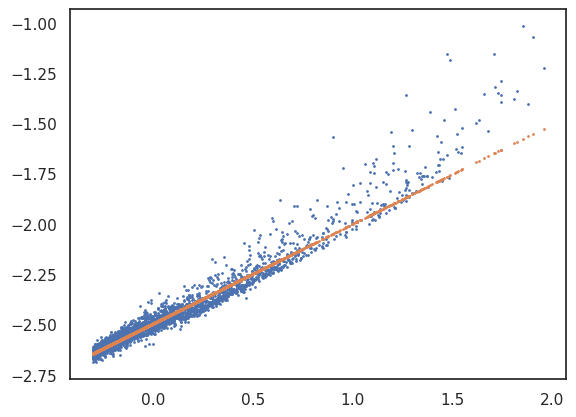

In [62]:
plt.scatter(np.log10(full_pop.genes.query('mean > 0.5')['mean']),
           full_pop.genes.query('mean > 0.5')['pairwise_p_cost'], s=1)

plt.scatter(np.log10(full_pop.genes.query('mean > 0.5')['mean']),
           pred_costs, s=1)

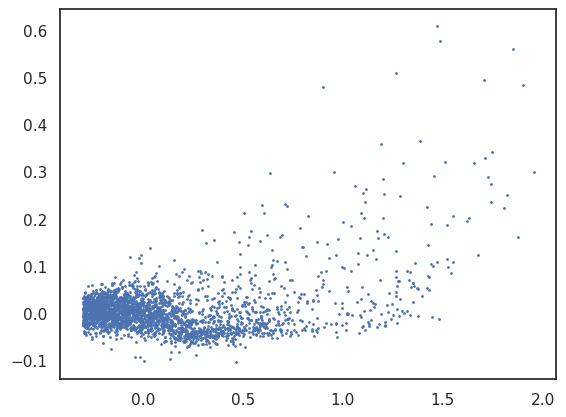

In [63]:
plt.scatter(np.log10(full_pop.genes.query('mean > 0.5')['mean']),
           full_pop.genes.query('mean > 0.5')['mean_adjusted_pairwise_p_cost'], s=1)

## Fitting excess CV

In [67]:
from scipy.signal import medfilt
from scipy.interpolate import interp1d

def calculate_excess_cv(pop, mean_threshold=0.05, exclude=[], resolution=1000):
    """Calculates the excess coefficient of variation (CV) for each gene.
    
    Args:
        pop: CellPopulation instance
        mean_threshold: only consider genes with mean expression level above this value
        exclude: list of gene names or gene ids to not include in the calculation
        resolution: number of bins to use when interpolating mean-CV relationship
        
    Returns:
        Series of excess CV for each gene.
    """
    if len(exclude) > 0:
        exclude = pop.gene_ids(exclude)
    
    thresholded_genes = pop.genes.query('mean > @mean_threshold').sort_values('mean', ascending=False)
    thresholded_genes = thresholded_genes.query('index not in @exclude')
    
    gene_means_mean_ordered = thresholded_genes['mean']
    gene_cvs_mean_ordered = thresholded_genes['cv']
    gene_cvs_mean_ordered_medfilt = pd.Series(medfilt(gene_cvs_mean_ordered, kernel_size=15), index=gene_cvs_mean_ordered.index)
    
    ind = np.arange(0, len(gene_means_mean_ordered), len(gene_means_mean_ordered)/resolution)
    cv_interpolater = interp1d(gene_means_mean_ordered.iloc[ind], gene_cvs_mean_ordered_medfilt.iloc[ind], fill_value="extrapolate")
    
    predicted_cv = pd.Series(cv_interpolater(gene_means_mean_ordered), index=gene_means_mean_ordered.index)
    excess_cv = gene_cvs_mean_ordered/predicted_cv
    thresholded_genes['excess_cv'] = excess_cv
    
    return thresholded_genes['excess_cv']


In [69]:
full_pop.genes['excess_cv'] = calculate_excess_cv(full_pop, mean_threshold=0.195)

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='excess_cv', ylabel='Density'>

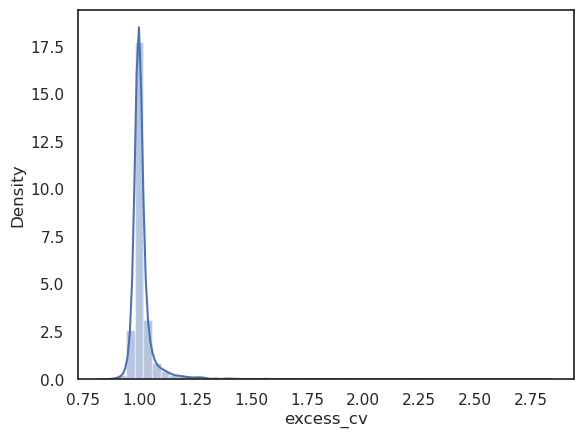

In [70]:
sns.distplot(full_pop.genes['excess_cv'])

In [71]:
full_pop.genes['excess_cv'].describe()

count    5500.000000
mean        1.012612
std         0.068129
min         0.863590
25%         0.990356
50%         1.000000
75%         1.013335
max         2.805001
Name: excess_cv, dtype: float64

/data/norman/tmn/envs/analysis38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mean_adjusted_pairwise_p_cost', ylabel='Density'>

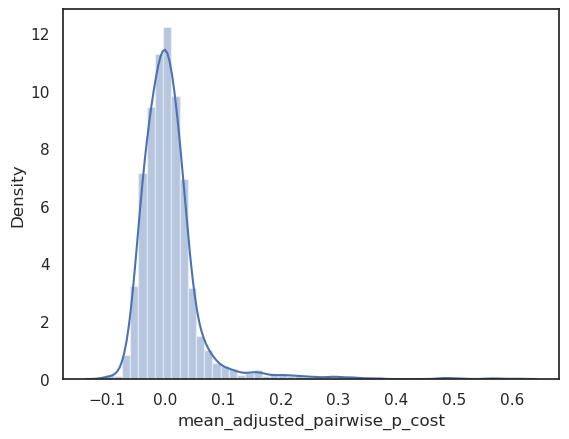

In [72]:
sns.distplot(full_pop.genes['mean_adjusted_pairwise_p_cost'])

## Picking stably captured genes

In [76]:
full_pop.genes['pairwise_chosen'] = full_pop.genes.index.isin(full_pop.genes.dropna(subset='mean_adjusted_pairwise_p_cost').query('excess_cv < 1 and mean_adjusted_pairwise_p_cost < {0:0.8f}'.format(full_pop.genes['mean_adjusted_pairwise_p_cost'].quantile(0.3))).index)

In [78]:
full_pop.genes['pairwise_chosen'].sum()

233

# Fit scale coefficients to stable genes

In [79]:
from joblib import Parallel, delayed
from sklearn.linear_model import HuberRegressor

def fit_robust_regression(x, y, name=None, fit_intercept=False):
    # Convert pandas series to numpy array as required by sklearn
    x_np = x.to_numpy().reshape(-1, 1)
    y_np = y.to_numpy()
    
    # Instantiate a HuberRegressor object with no intercept
    huber = HuberRegressor(fit_intercept=fit_intercept, max_iter=500)
    
    # Fit the Huber regression model to the data
    try:
        huber.fit(x_np, y_np)
        coef = huber.coef_[0]
        umi_pred = huber.predict(x_np).sum()
        raw_umi_pred = x_np.sum()
    except ValueError:
        coef = np.nan
        umi_pred = np.nan
        raw_umi_pred = np.nan
        
    if not fit_intercept:
        if name is None:
            return (coef, umi_pred, raw_umi_pred)
        else:
            return (name, coef, umi_pred, raw_umi_pred)
    else:
        if name is None:
            return (coef, huber.intercept_, umi_pred, raw_umi_pred)
        else:
            return (name, coef, huber.intercept_, umi_pred, raw_umi_pred)

def get_mean_coefs(pop, stable_genes, trim=None, fit_intercept=False):    
    all_coefs = dict()
    
    for gem in tqdm(pop.cells['gem_group'].unique()):
        for num in pop.cells['num_cells'].unique():
            target_cells = pop.cells[(pop.cells['gem_group']==gem) & (pop.cells['num_cells']==num)].index
            stable_expr = pop.where(cells=target_cells,
                                    genes=stable_genes)
            if trim is None:
                stable_mean_expr = stable_expr.mean()
            else:
                stable_mean_expr = stable_expr.apply(lambda x: trim_mean(x, trim))

            coefs = Parallel(n_jobs=16, verbose=10)(delayed(fit_robust_regression)(row, stable_mean_expr, name=cell_bc, fit_intercept=fit_intercept) for cell_bc, row in stable_expr.iterrows())

            if not fit_intercept:
                all_coefs[(gem, num)] = pd.DataFrame(coefs, columns=['cell_barcode', 'huber_coef', 'huber_UMI_count', 'raw_huber_UMI_count']).set_index('cell_barcode')
            else:
                all_coefs[(gem, num)] = pd.DataFrame(coefs,
                                              columns=['cell_barcode', 'huber_intercept_coef', 'huber_intercept', 'huber_intercept_UMI_count', 'raw_huber_intercept_UMI_count']).set_index('cell_barcode')
    
    return pd.concat(all_coefs.values())

In [80]:
pairwise_mean_coefs = get_mean_coefs(full_pop, full_pop.genes.query('pairwise_chosen').index)

  0%|          | 0/20 [00:00<?, ?it/s]

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:  1.0min
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:  1.0min
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:  1.0min
[Parallel(n_jobs=16)]: Batch computation too fast (0.1961327341273143s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done  53 tasks      | elapsed:  1.0min
[Parallel(n_jobs=16)]: Done  66 tasks      | elapsed:  1.0min
[Parallel(n_jobs=16)]: Batch computation too fast (0.0875539779663086s.) Setting batch_size=4.
[Parallel(n_jobs=16)]: Done  83 tasks      | elapsed:  1.0min
[Parallel(n_jobs=16)]: Done 113 tasks      | elapsed:  1.0min
[Parallel(n_jobs=16)]: Batch computation too fast (0.0975339412689209s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 151 tasks      | elapsed:  1.0min
[Parallel(n_jobs=16)]: Done 216 tasks      | elapsed:  1.0min
[Parallel(n_jobs=1

[Parallel(n_jobs=16)]: Done 8320 tasks      | elapsed:    3.1s
[Parallel(n_jobs=16)]: Done 9248 tasks      | elapsed:    3.4s
[Parallel(n_jobs=16)]: Done 10240 tasks      | elapsed:    3.9s
[Parallel(n_jobs=16)]: Done 11232 tasks      | elapsed:    4.2s
[Parallel(n_jobs=16)]: Done 12288 tasks      | elapsed:    4.4s
[Parallel(n_jobs=16)]: Batch computation too fast (0.19065543661980552s.) Setting batch_size=64.
[Parallel(n_jobs=16)]: Done 12600 tasks      | elapsed:    4.5s
[Parallel(n_jobs=16)]: Done 12821 tasks      | elapsed:    4.6s
[Parallel(n_jobs=16)]: Done 12856 tasks      | elapsed:    4.6s
[Parallel(n_jobs=16)]: Done 12893 tasks      | elapsed:    4.7s
[Parallel(n_jobs=16)]: Done 12930 tasks      | elapsed:    4.8s
[Parallel(n_jobs=16)]: Done 12977 out of 12977 | elapsed:    4.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.025368690490722656s.) Setting batch_size=2.
[Parallel(n_jobs

[Parallel(n_jobs=16)]: Done 2080 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 2816 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 3552 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done 4352 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 5152 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 6016 tasks      | elapsed:    2.5s
[Parallel(n_jobs=16)]: Done 6880 tasks      | elapsed:    2.7s
[Parallel(n_jobs=16)]: Done 7808 tasks      | elapsed:    3.0s
[Parallel(n_jobs=16)]: Done 8736 tasks      | elapsed:    3.5s
[Parallel(n_jobs=16)]: Done 9728 tasks      | elapsed:    3.8s
[Parallel(n_jobs=16)]: Done 10720 tasks      | elapsed:    4.0s
[Parallel(n_jobs=16)]: Done 11776 tasks      | elapsed:    4.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.19976609334597012s.) Setting batch_size=64.
[Parallel(n_jobs=16)]: Done 11995 tasks      | elapsed:    4.3s
[Parallel(n_jobs=16)]: Done 12278 tasks      | elapsed:    4.3s
[Parallel(n_jobs=

[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Batch computation too fast (0.17106270790100098s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 1920 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 2592 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 3328 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 4064 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 4864 tasks      | elapsed:    2.2s
[Parallel(n_jobs=16)]: Done 5664 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 6528 tasks      | elapsed:    2.6s
[Parallel(n_jobs=16)]: Done 7392 tasks      | elapsed:    2.8s
[Parallel(n_jobs=16)]: Batch computation too fast (0.19934853461725716s.) Setting batch_size=64.
[Parallel(n_jobs=16)]: Done 7960 tasks      | elapsed

[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Batch computation too fast (0.16168785095214844s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 1920 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 2592 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 3328 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 4064 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done 4864 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 5664 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 6528 tasks      | elapsed:    2.5s
[Parallel(n_jobs=16)]: Done 7392 tasks      | elapsed:    2.7s
[Parallel(n_jobs=16)]: Done 8320 tasks      | elapsed:    3.0s
[Parallel(n_jobs=16)]: Done 9248 tasks      | elapsed:    3.2s
[Parallel(n_jobs=16)]: D

[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.09648561477661133s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 164 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 224 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Batch computation too fast (0.1437668800354004s.) Setting batch_size=16.
[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Batch computation too fast (0.15137696266174316s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 1920 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Batch computation too fast (0.19761313430340782s.) Setting batch_size=64.
[Parallel(n_jobs=16)]: Done 2592 tasks      | elapsed:

[Parallel(n_jobs=16)]: Batch computation too fast (0.14633464813232422s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 1920 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 2592 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 3328 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 4064 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 4864 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done 5664 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 6528 tasks      | elapsed:    2.5s
[Parallel(n_jobs=16)]: Done 7392 tasks      | elapsed:    2.7s
[Parallel(n_jobs=16)]: Done 8320 tasks      | elapsed:    3.0s
[Parallel(n_jobs=16)]: Done 9248 tasks      | elapsed:    3.3s
[Parallel(n_jobs=16)]: Done 10240 tasks      | elapsed:    3.5s
[Parallel(n_jobs=16)]:

[Parallel(n_jobs=16)]: Done 3048 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 3156 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 3264 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 3464 out of 3495 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 3495 out of 3495 | elapsed:    1.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.03675127029418945s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Batch computation too fast (0.09392356872558594s.) Setting batch_size=4.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.10046982765197754s.) Se

[Parallel(n_jobs=16)]: Batch computation too fast (0.08977222442626953s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 164 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 224 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Batch computation too fast (0.1189420223236084s.) Setting batch_size=16.
[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Batch computation too fast (0.14713692665100098s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 1920 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Batch computation too fast (0.19207477626152086s.) Setting batch_size=64.
[Parallel(n_jobs=16)]: Done 2561 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 2801 tasks      | elapsed

[Parallel(n_jobs=16)]: Done 6210 tasks      | elapsed:    2.5s
[Parallel(n_jobs=16)]: Done 6241 tasks      | elapsed:    2.6s
[Parallel(n_jobs=16)]: Done 6272 tasks      | elapsed:    2.7s
[Parallel(n_jobs=16)]: Done 6312 out of 6312 | elapsed:    2.7s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.04546928405761719s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Batch computation too fast (0.08763360977172852s.) Setting batch_size=4.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.09981393814086914s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.3s
[

[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Batch computation too fast (0.1513073444366455s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 1920 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 2592 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 3328 tasks      | elapsed:    1.6s
[Parallel(n_jobs=16)]: Done 4064 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Batch computation too fast (0.19704050677606766s.) Setting batch_size=64.
[Parallel(n_jobs=16)]: Done 4714 tasks      | elapsed:    1.8s
[Parallel(n_jobs=16)]: Done 5034 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 5178 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 5232 tasks      | elapsed:    2.0s
[Parallel(n_jobs=16)]: Done 5290 tasks      | elapsed:

[Parallel(n_jobs=16)]: Done 13344 tasks      | elapsed:    4.6s
[Parallel(n_jobs=16)]: Batch computation too fast (0.19169627042589726s.) Setting batch_size=64.
[Parallel(n_jobs=16)]: Done 14404 tasks      | elapsed:    4.8s
[Parallel(n_jobs=16)]: Done 14864 tasks      | elapsed:    4.9s
[Parallel(n_jobs=16)]: Done 14938 tasks      | elapsed:    5.0s
[Parallel(n_jobs=16)]: Done 15012 tasks      | elapsed:    5.0s
[Parallel(n_jobs=16)]: Done 15090 tasks      | elapsed:    5.1s
[Parallel(n_jobs=16)]: Done 15128 out of 15159 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=16)]: Done 15159 out of 15159 | elapsed:    5.1s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.023262500762939453s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.1s

[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Batch computation too fast (0.19863457600021286s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 1120 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 1456 tasks      | elapsed:    1.2s
[Parallel(n_jobs=16)]: Done 2080 tasks      | elapsed:    1.4s
[Parallel(n_jobs=16)]: Done 2816 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 3552 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 4352 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 5152 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 6016 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 6880 tasks      | elapsed:    2.6s
[Parallel(n_jobs=16)]: Done 7808 tasks      | elapsed:    2.8s
[Parallel(n_jobs=16)]: Done 8736 tasks      | elapsed:    3.2s
[Parallel(n_jobs=16)]: D

[Parallel(n_jobs=16)]: Done 5664 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 6528 tasks      | elapsed:    2.5s
[Parallel(n_jobs=16)]: Done 7392 tasks      | elapsed:    2.8s
[Parallel(n_jobs=16)]: Done 8320 tasks      | elapsed:    3.0s
[Parallel(n_jobs=16)]: Done 9248 tasks      | elapsed:    3.3s
[Parallel(n_jobs=16)]: Done 10240 tasks      | elapsed:    3.5s
[Parallel(n_jobs=16)]: Done 11232 tasks      | elapsed:    3.8s
[Parallel(n_jobs=16)]: Done 12288 tasks      | elapsed:    4.0s
[Parallel(n_jobs=16)]: Done 13344 tasks      | elapsed:    4.5s
[Parallel(n_jobs=16)]: Done 14464 tasks      | elapsed:    4.8s
[Parallel(n_jobs=16)]: Done 15584 tasks      | elapsed:    5.1s
[Parallel(n_jobs=16)]: Batch computation too fast (0.19525955056861005s.) Setting batch_size=64.
[Parallel(n_jobs=16)]: Done 16738 tasks      | elapsed:    5.3s
[Parallel(n_jobs=16)]: Done 16932 tasks      | elapsed:    5.3s
[Parallel(n_jobs=16)]: Done 17010 tasks      | elapsed:    5.4s
[Parallel(n_

[Parallel(n_jobs=16)]: Done 6472 tasks      | elapsed:    2.6s
[Parallel(n_jobs=16)]: Done 6617 tasks      | elapsed:    2.7s
[Parallel(n_jobs=16)]: Done 6762 tasks      | elapsed:    2.7s
[Parallel(n_jobs=16)]: Done 6973 out of 6973 | elapsed:    2.8s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.02462291717529297s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Batch computation too fast (0.07596230506896973s.) Setting batch_size=4.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.08949756622314453s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.01757073402404785s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Batch computation too fast (0.11300826072692871s.) Setting batch_size=4.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.09414792060852051s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 164 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 224 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Batch computation too fast (0.10280561447143555s.) Setting batch_size=16.
[Parallel(n_jobs=16)]: Done 360 tasks     

[Parallel(n_jobs=16)]: Done 3328 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 4064 tasks      | elapsed:    1.7s
[Parallel(n_jobs=16)]: Done 4864 tasks      | elapsed:    1.9s
[Parallel(n_jobs=16)]: Done 5664 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 6528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 7392 tasks      | elapsed:    2.6s
[Parallel(n_jobs=16)]: Done 8320 tasks      | elapsed:    3.0s
[Parallel(n_jobs=16)]: Done 9248 tasks      | elapsed:    3.3s
[Parallel(n_jobs=16)]: Done 10240 tasks      | elapsed:    3.4s
[Parallel(n_jobs=16)]: Batch computation too fast (0.19377583170202592s.) Setting batch_size=64.
[Parallel(n_jobs=16)]: Done 10519 tasks      | elapsed:    3.5s
[Parallel(n_jobs=16)]: Done 10769 tasks      | elapsed:    3.6s
[Parallel(n_jobs=16)]: Done 10802 tasks      | elapsed:    3.6s
[Parallel(n_jobs=16)]: Done 10837 tasks      | elapsed:    3.7s
[Parallel(n_jobs=16)]: Done 10872 tasks      | elapsed:    3.8s
[Parallel(n_job

[Parallel(n_jobs=16)]: Done 11776 tasks      | elapsed:    4.0s
[Parallel(n_jobs=16)]: Done 12832 tasks      | elapsed:    4.6s
[Parallel(n_jobs=16)]: Done 13952 tasks      | elapsed:    4.9s
[Parallel(n_jobs=16)]: Done 15072 tasks      | elapsed:    5.1s
[Parallel(n_jobs=16)]: Batch computation too fast (0.1980886579300038s.) Setting batch_size=64.
[Parallel(n_jobs=16)]: Done 15851 out of 15851 | elapsed:    5.2s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.02597498893737793s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.1340169906616211s.) Setting batch_size=4.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    

[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.1101694107055664s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 164 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 224 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Batch computation too fast (0.13429641723632812s.) Setting batch_size=16.
[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Batch computation too fast (0.15372943878173828s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 1920 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 2592 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 3328 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Do

[Parallel(n_jobs=16)]: Done 8320 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done 9248 tasks      | elapsed:    3.2s
[Parallel(n_jobs=16)]: Done 10240 tasks      | elapsed:    3.6s
[Parallel(n_jobs=16)]: Done 11232 tasks      | elapsed:    3.9s
[Parallel(n_jobs=16)]: Done 12288 tasks      | elapsed:    4.2s
[Parallel(n_jobs=16)]: Done 13344 tasks      | elapsed:    4.5s
[Parallel(n_jobs=16)]: Done 14464 tasks      | elapsed:    4.8s
[Parallel(n_jobs=16)]: Done 15584 tasks      | elapsed:    5.1s
[Parallel(n_jobs=16)]: Done 16768 tasks      | elapsed:    5.3s
[Parallel(n_jobs=16)]: Batch computation too fast (0.19655594142305183s.) Setting batch_size=64.
[Parallel(n_jobs=16)]: Done 17208 tasks      | elapsed:    5.4s
[Parallel(n_jobs=16)]: Done 17433 tasks      | elapsed:    5.5s
[Parallel(n_jobs=16)]: Done 17472 tasks      | elapsed:    5.5s
[Parallel(n_jobs=16)]: Done 17532 out of 17532 | elapsed:    5.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concu

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.04100608825683594s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Batch computation too fast (0.08405327796936035s.) Setting batch_size=4.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.0918722152709961s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 164 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 224 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Batch computation too fast (0.10612297058105469s.) Setting batch_size=16.
[Parallel(n_jobs=16)]: Done 360 tasks      

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Batch computation too fast (0.038445234298706055s.) Setting batch_size=2.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Batch computation too fast (0.09019064903259277s.) Setting batch_size=4.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.09276819229125977s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 164 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 224 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Batch computation too fast (0.12014937400817871s.) Setting batch_size=16.
[Parallel(n_jobs=16)]: Done 360 tasks    

[Parallel(n_jobs=16)]: Done  74 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Batch computation too fast (0.09297680854797363s.) Setting batch_size=8.
[Parallel(n_jobs=16)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 164 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 224 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Batch computation too fast (0.12563133239746094s.) Setting batch_size=16.
[Parallel(n_jobs=16)]: Done 360 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Batch computation too fast (0.19657588005065918s.) Setting batch_size=32.
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 816 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    1.0s
[Parallel(n_jobs=16)]: Done 1920 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 2592 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done 3328 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: D

In [81]:
pairwise_mean_coefs['UMI_count'] = full_pop.cells['UMI_count']
pairwise_mean_coefs['num_cells'] = full_pop.cells['num_cells']
pairwise_mean_coefs['pred_UMI_count'] = pairwise_mean_coefs['UMI_count']*pairwise_mean_coefs['huber_coef']
pairwise_mean_coefs['gem_group'] = full_pop.cells['gem_group']

In [82]:
sns.set_style('white')

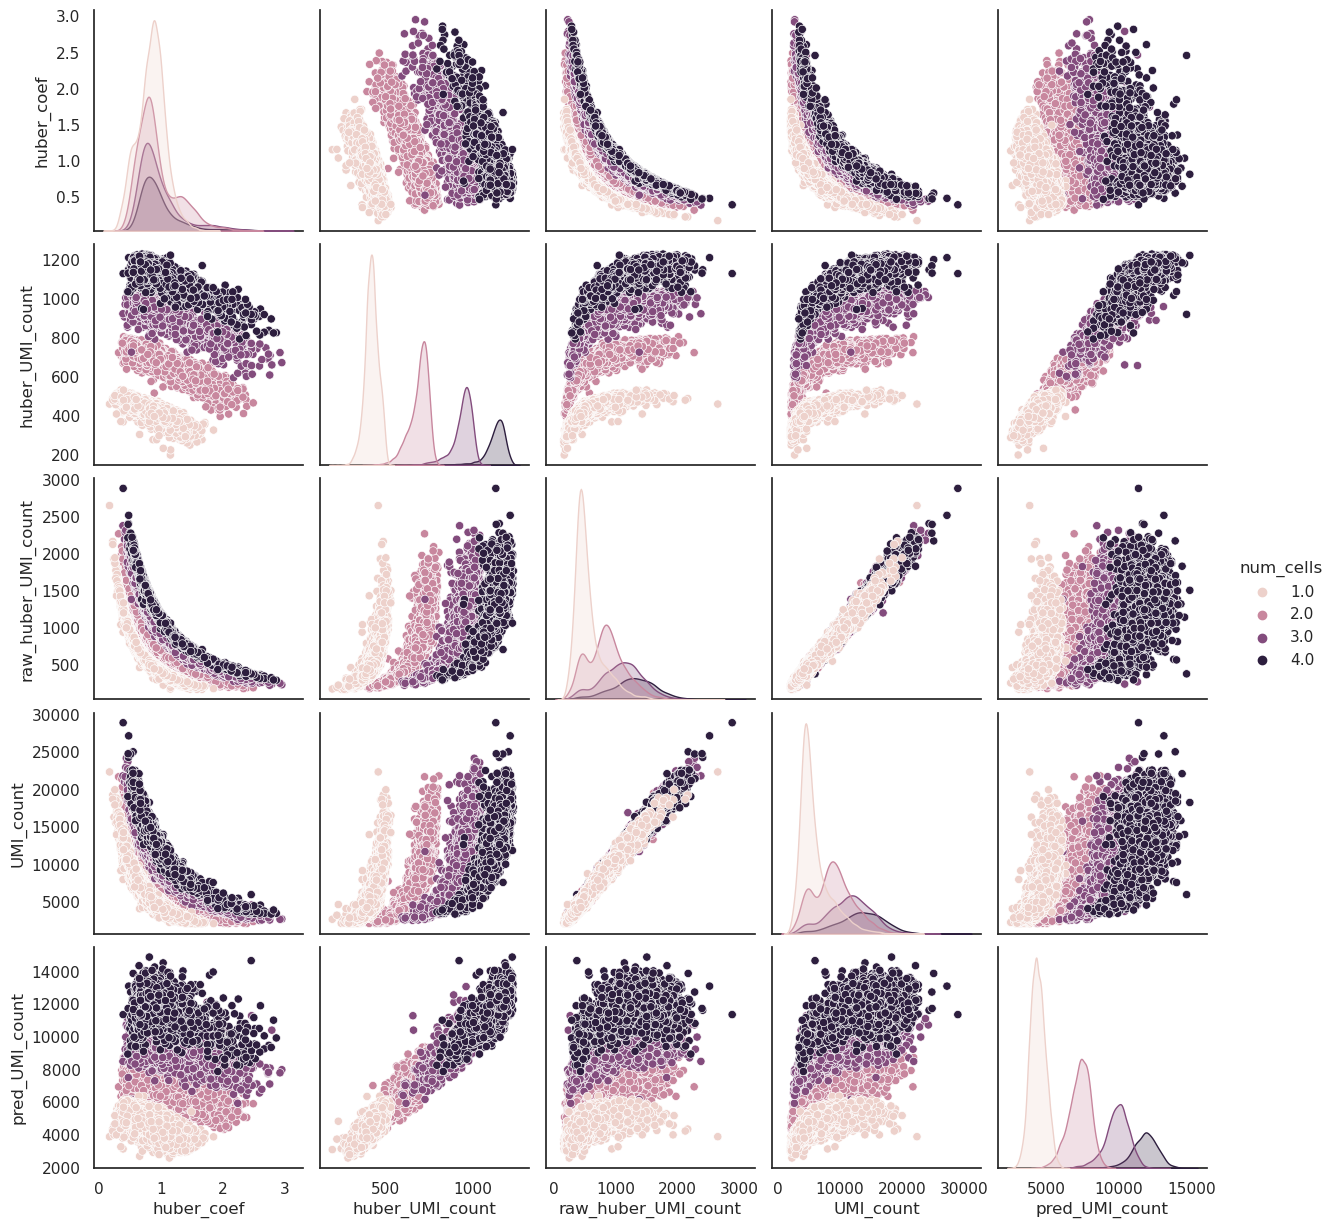

In [83]:
sns.pairplot(pairwise_mean_coefs.query('gem_group==1').drop('gem_group', axis=1), hue='num_cells')

In [84]:
full_pop.cells['pairwise_coef'] = pairwise_mean_coefs['huber_coef']
full_pop.cells['pairwise_UMI_count'] = pairwise_mean_coefs['pred_UMI_count']

In [89]:
full_pop.cells['pairwise_singlet_equivalent_UMI_count'] = full_pop.cells['pairwise_UMI_count']/full_pop.cells.groupby(['gem_group', 'num_cells'])['pairwise_UMI_count'].transform('median')

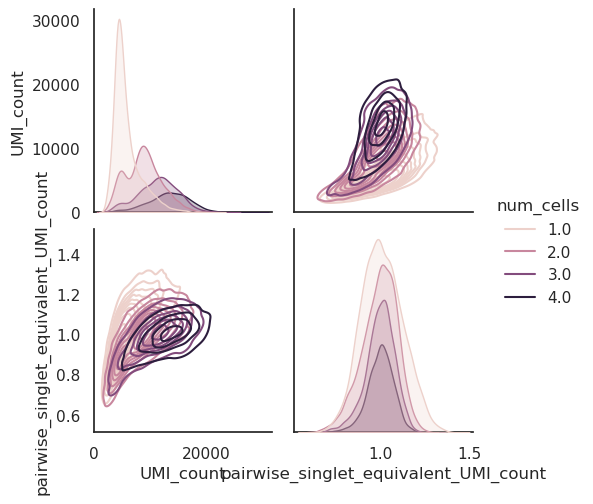

In [91]:
sns.pairplot(full_pop.cells.query('gem_group==1')[['UMI_count', 'pairwise_singlet_equivalent_UMI_count', 'num_cells']],
             hue='num_cells', kind='kde')

# Normalize capture probabilities

In [92]:
from scipy.stats import trim_mean

def p_normalize(pop, genes=None, UMI_counts=None, UMI_constant=10000, normalize_to_constant=True, scale_by_num_cells=False, normalize_to_singlets=False, trim=False, proportion_to_cut=0.02):
    if UMI_counts is None:
        UMI_counts = pop.cells['UMI_count']
    
    normalized = dict()
    
    for gem in tqdm(pop.cells['gem_group'].unique()):
        gem_group_cells = pop.cells[pop.cells['gem_group']==gem].index
        
        p = pop.where(cells=gem_group_cells, genes=genes).copy()
        # normalize to probabilities
        p = p.div(UMI_counts.loc[gem_group_cells], axis=0)
        
        p['num_cells'] = pop.cells['num_cells']
        p.set_index('num_cells', append=True, inplace=True)
        
        # observed average probability per transcript by num_cells
        if trim: # trimmed mean to reduce dependence on outliers
            P = dict()
            for level, df in p.groupby(level=1):
                P[level] = df.apply(lambda x: trim_mean(x, proportion_to_cut))
            P = pd.DataFrame(P).T
        else:
            P = p.groupby(level=1).mean()
        
        if normalize_to_singlets:
            mu = P.loc[1]
        else:
            if trim:
                mu = p.apply(lambda x: trim_mean(x, proportion_to_cut))
            else:
                mu = p.mean()
        
        # normalize to equal average probability across all droplets to yield scale factors
        Q = P.div(mu)
        
        factors = pd.DataFrame(Q.loc[p.index.get_level_values(1)].values, index=p.index, columns=p.columns)
        
        if normalize_to_constant and scale_by_num_cells:
            # normalize singlets to 10k, doublets to 20k, triplets to 30k, etc.
            p = (p/factors).mul(p.index.get_level_values(1)*UMI_constant, axis=0).droplevel(1)
        elif normalize_to_constant and not scale_by_num_cells:
            # normalize all to 10k
            p = (p/factors).droplevel(1)*UMI_constant
        else:
            # normalize back by original observed number of UMIs
            p = (p/factors).droplevel(1).mul(UMI_counts.loc[gem_group_cells], axis=0)
            
        normalized[gem] = p
    
    return pd.concat(normalized.values())

In [107]:
adata = sc.AnnData(X=csr_matrix(full_pop.matrix),
                   obs=full_pop.cells,
                   var=full_pop.genes)

In [ ]:
adata.write('/data/norman/southark/tfs_standardized/240308_RPE1_CRISPRa_final_population.h5ad')